# `dtreeviz` XGBoost Examples

([View this notebook in Colab](https://colab.research.google.com/github/parrt/dtreeviz/blob/master/notebooks/dtreeviz_xgboost_visualisations.ipynb))

The [dtreeviz](https://github.com/parrt/dtreeviz) library is designed to help machine learning practitioners visualize and interpret decision trees and decision-tree-based models, such as gradient boosting machines.  

The purpose of this notebook is to illustrate the main capabilities and functions of the dtreeviz API. To do that, we will use XGBoost and the toy but well-known Titanic data set for illustrative purposes.  Currently, dtreeviz supports the following decision tree libraries:

* [scikit-learn](https://scikit-learn.org/stable)
* [XGBoost](https://xgboost.readthedocs.io/en/latest)
* [Spark MLlib](https://spark.apache.org/mllib/)
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
* [Tensorflow](https://www.tensorflow.org/decision_forests)

To interopt with these different libraries, dtreeviz uses an adaptor object, obtained from function `dtreeviz.model()`, to extract model information necessary for visualization. Given such an adaptor object, all of the dtreeviz functionality is available to you using the same programmer interface. The basic dtreeviz usage recipe is:

1. Import dtreeviz and your decision tree library
2. Acquire and load data into memory
3. Train a classifier or regressor model using your decision tree library
4. Obtain a dtreeviz adaptor model using<br>`viz_model = dtreeviz.model(your_trained_model,...)`
5. Call dtreeviz functions, such as<br>`viz_model.view()` or `viz_model.explain_prediction_path(sample_x)`

The four categories of dtreeviz functionality are:

1. Tree visualizations
2. Prediction path explanations
3. Leaf information
4. Feature space exploration

We have grouped code examples by [classifiers](#Classifiers) and [regressors](#Regressors), with a follow up section on [partitioning feature space](#Feature-Space-Partitioning).

*These examples require dtreeviz 2.0 or above because the code uses the new API introduced in 2.0.*

## Setup

In [1]:
import sys
import os

In [2]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz
  !pip install -q xgboost==1.5.0

In [3]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np

random_state = 1234 # get reproducible trees

/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load Sample Data

In [4]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv"
dataset = pd.read_csv(dataset_url)
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

# Classifiers

To demonstrate classifier decision trees, we trying to model using six features to predict the boolean survived target.

In [5]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

dtrain = xgb.DMatrix(dataset[features], dataset[target])

params = {"max_depth":3, "eta":0.05, "objective":"binary:logistic", "subsample":1}
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=8)

[13:19:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Initialize dtreeviz model (adaptor)

To adapt dtreeviz to a specific model, use the `model()` function to get an adaptor.  You'll need to provide the model, X/y data, feature names, target name, and target class names:

In [6]:
viz_model = dtreeviz.model(xgb_model, tree_index=1,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["survive", "perish"])

We'll use this model to demonstrate dtreeviz functionality in the following sections; the code will look the same for any decision tree library once we have this model adaptor.m

## Tree structure visualizations

To show the decision tree structure using the default visualization, call `view()`:

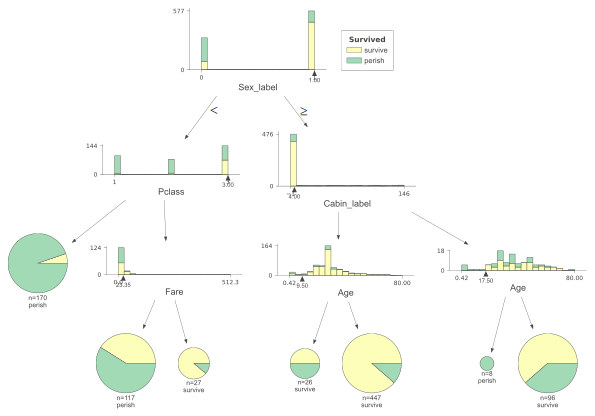

In [7]:
viz_model.view()

To change the visualization, you can pass parameters, such as changing the orientation to left-to-right:

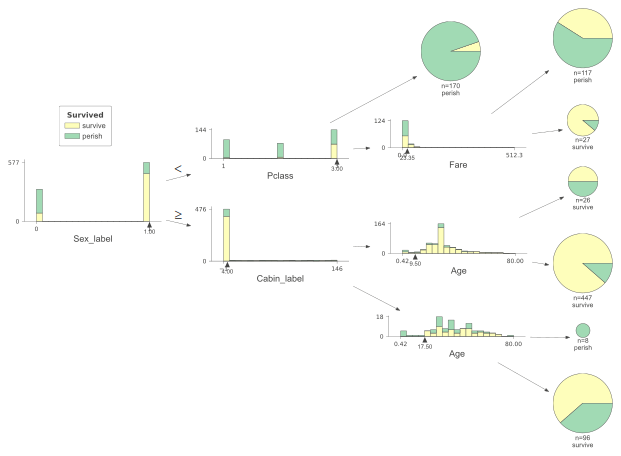

In [8]:
viz_model.view(orientation="LR")

To visualize larger trees, you can reduce the amount of detail by turning off the fancy view:

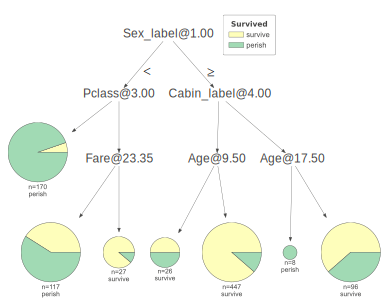

In [9]:
viz_model.view(fancy=False)

Another way to reduce the visualization size is to specify the tree depths of interest:

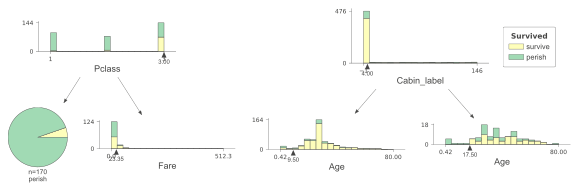

In [10]:
viz_model.view(depth_range_to_display=(1, 2)) # root is level 0

## Prediction path explanations

For interpretation purposes, we often want to understand how a tree behaves for a specific instance. Let's pick a specific instance:

In [11]:
x = dataset[features].iloc[10]
x

Pclass              3.0
Age                 4.0
Fare               16.7
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Name: 10, dtype: float64

and then display the path through the tree structure:

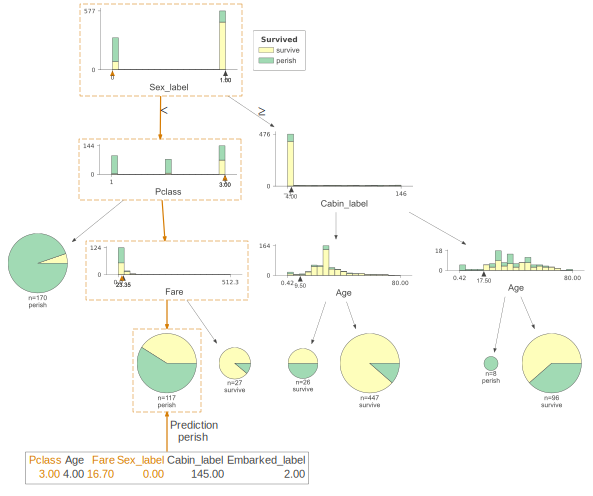

In [12]:
viz_model.view(x=x)

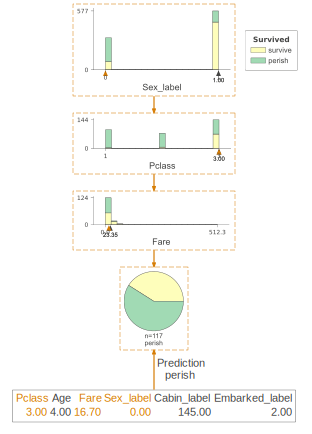

In [13]:
viz_model.view(x=x, show_just_path=True)

You can also get a string representation explaining the comparisons made as an instance is run down the tree:

In [14]:
print(viz_model.explain_prediction_path(x))

3.0 <= Pclass 
Fare < 23.35
Sex_label < 1.0



## Leaf info

There are a number of functions to get information about the leaves of the tree.

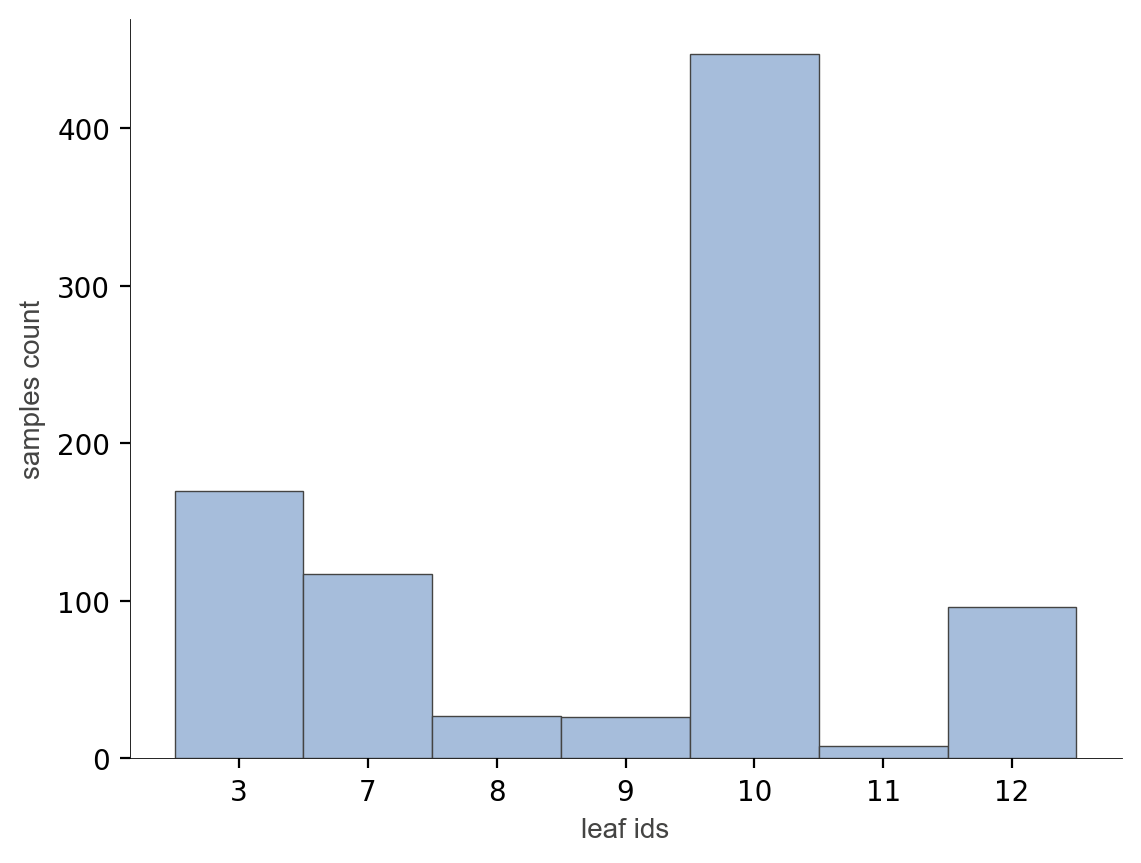

In [15]:
viz_model.leaf_sizes()

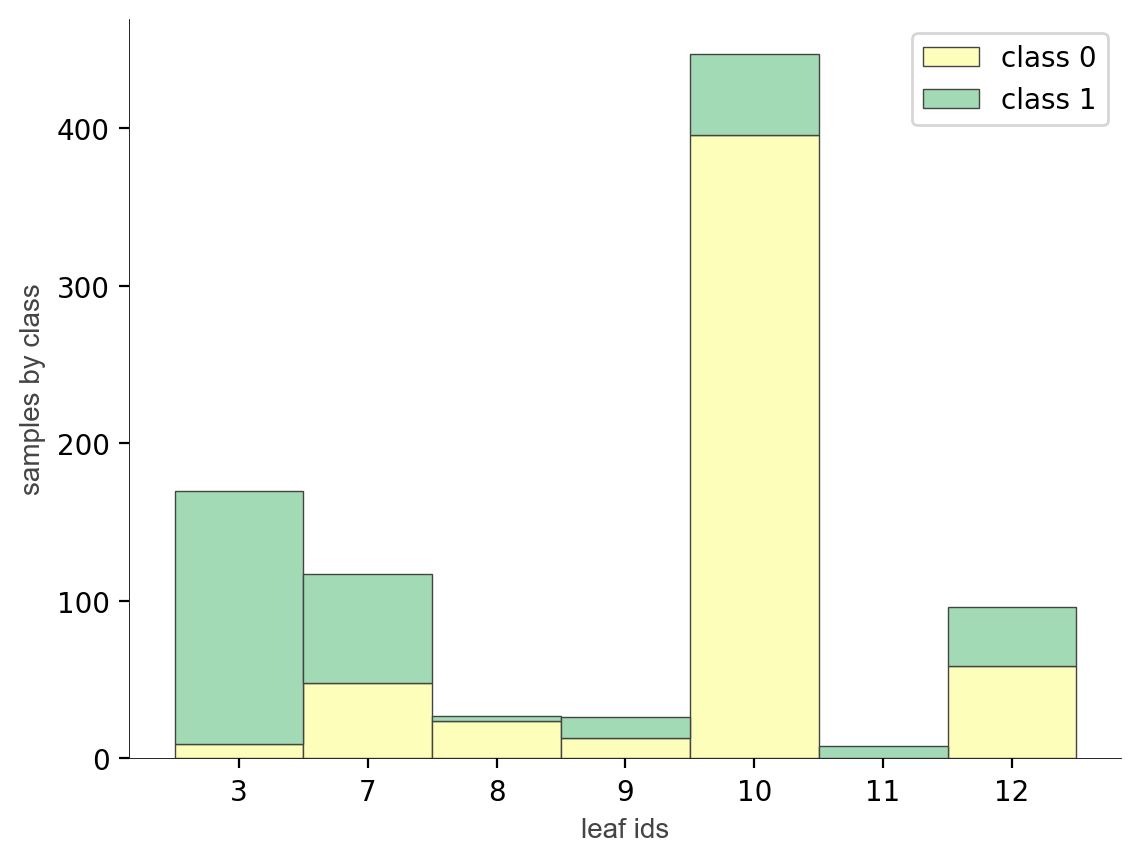

In [16]:
viz_model.ctree_leaf_distributions()

In [17]:
viz_model.node_stats(node_id=10)

Pclass         Age        Fare  Sex_label  Cabin_label  \
count  447.000000  447.000000  447.000000      447.0   447.000000   
mean     2.651007   30.389708   15.691562        1.0    -0.984340   
std      0.601860   10.331575   18.782897        0.0     0.216424   
min      1.000000   10.000000    0.000000        1.0    -1.000000   
25%      2.000000   24.000000    7.775000        1.0    -1.000000   
50%      3.000000   29.699118    8.050000        1.0    -1.000000   
75%      3.000000   33.000000   15.500000        1.0    -1.000000   
max      3.000000   74.000000  227.525000        1.0     3.000000   

       Embarked_label  
count      447.000000  
mean         1.644295  
std          0.712544  
min          0.000000  
25%          2.000000  
50%          2.000000  
75%          2.000000  
max          2.000000

# Regressors

To demonstrate regressor tree visualization, we start by creating a regressors model that predicts age instead of survival:

In [18]:
features_reg = ["Pclass", "Fare", "Sex_label", "Cabin_label", "Embarked_label", "Survived"]
target_reg = "Age"

dtrain_reg = xgb.DMatrix(dataset[features_reg], dataset[target_reg])
params_reg = {"max_depth":3, "eta":0.05, "objective":"reg:squarederror", "subsample":1}
xgb_model_reg = xgb.train(params=params_reg, dtrain=dtrain_reg, num_boost_round=8)

/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Initialize dtreeviz model (adaptor)

In [19]:
viz_rmodel = dtreeviz.model(model=xgb_model_reg, tree_index=1, 
                            X_train=dataset[features_reg], 
                            y_train=dataset[target_reg], 
                            feature_names=features_reg, 
                            target_name=target_reg)

## Tree structure visualisations

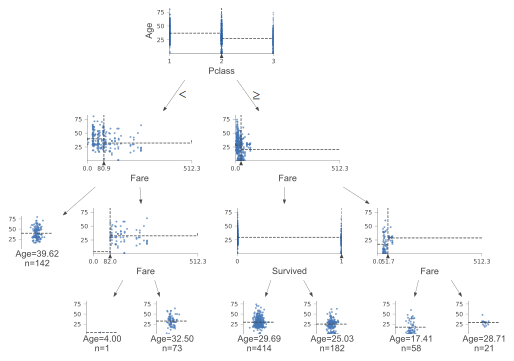

In [20]:
viz_rmodel.view()

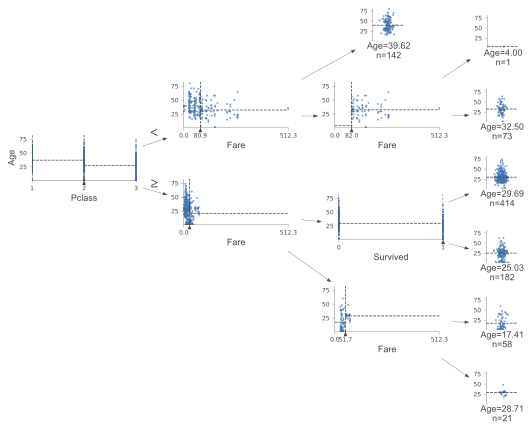

In [21]:
viz_rmodel.view(orientation="LR")

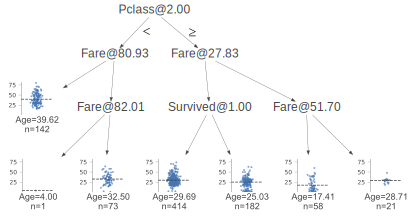

In [22]:
viz_rmodel.view(fancy=False)

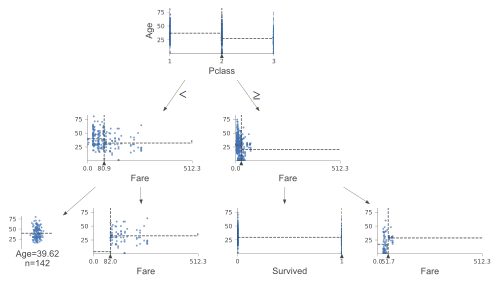

In [23]:
viz_rmodel.view(depth_range_to_display=(0, 2))

## Prediction path explanations


In [24]:
x = dataset[features_reg].iloc[10]
x

Pclass              3.0
Fare               16.7
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Survived            1.0
Name: 10, dtype: float64

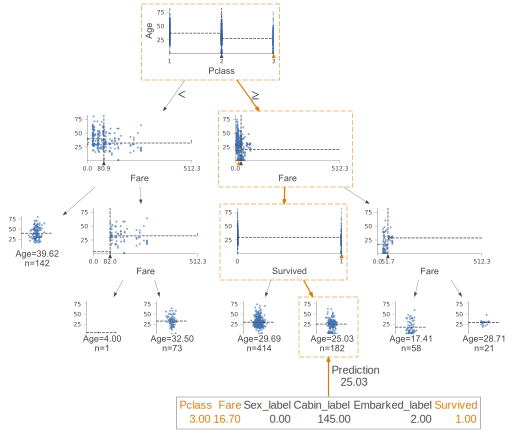

In [25]:
viz_rmodel.view(x = x)

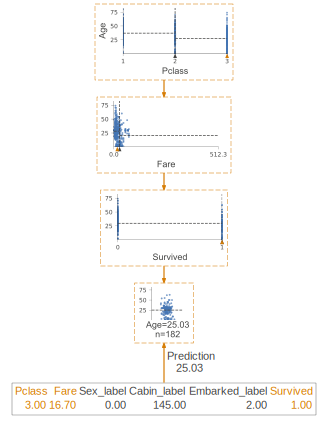

In [26]:
viz_rmodel.view(show_just_path=True, x = x)

In [27]:
print(viz_rmodel.explain_prediction_path(x))

2.0 <= Pclass 
Fare < 27.83
1.0 <= Survived 



## Leaf info

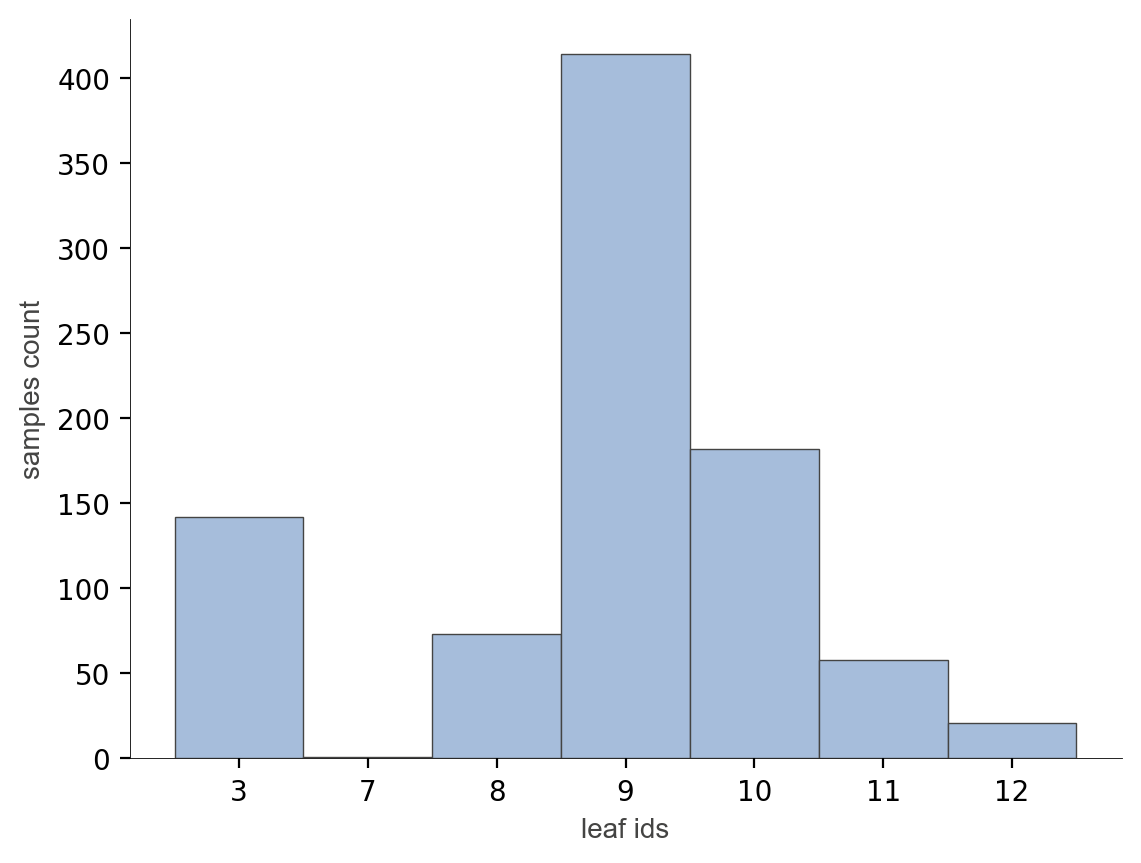

In [28]:
viz_rmodel.leaf_sizes()

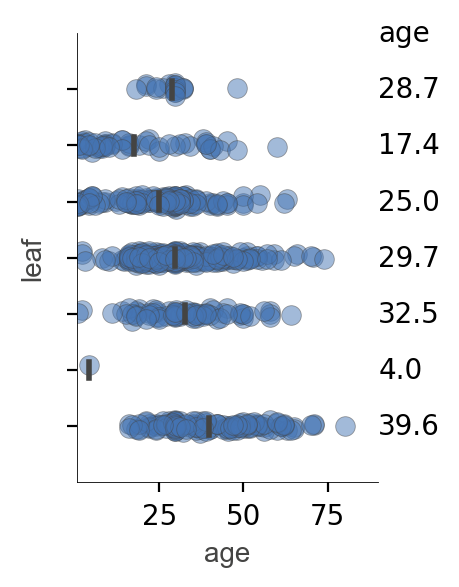

In [29]:
viz_rmodel.rtree_leaf_distributions()

In [30]:
viz_rmodel.node_stats(node_id=4)

Pclass        Fare  Sex_label  Cabin_label  Embarked_label  Survived
count    74.0   74.000000  74.000000    74.000000       74.000000  74.00000
mean      1.0  158.678826   0.351351    53.189189        0.945946   0.77027
std       0.0   93.216329   0.480651    34.263954        0.991635   0.42353
min       1.0   81.858300   0.000000    -1.000000        0.000000   0.00000
25%       1.0   91.684400   0.000000    32.500000        0.000000   1.00000
50%       1.0  133.650000   0.000000    59.500000        0.000000   1.00000
75%       1.0  211.337500   1.000000    77.750000        2.000000   1.00000
max       1.0  512.329200   1.000000   130.000000        2.000000   1.00000

# Feature Space Partitioning

Decision trees partition feature space in such a way as to maximize target value purity for the instances associated with a node. It's often useful to visualize the feature space partitioning, although it's not feasible to visualize more than a couple of dimensions.

*work in progress for this library*

See [Feature Space Partitioning for scikit-learn](dtreeviz_sklearn_visualisations.ipynb#Feature_Space_Partitioning) for now.